In [1]:
import torch
import pandas as pd
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

/Users/reeceshuttleworth/Dropbox/Mac (3)/Documents/GitHub/958/958/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
data = pd.read_json("entropies_tinystories.json")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:

averages, stds, maxs, mins = torch.zeros((24)), torch.zeros((24)), torch.zeros((24)), torch.zeros((24))
for storynum, story in enumerate(data):
    for layernum in range(24):
        # average of averages
        avg_val = torch.mean(torch.Tensor(data[story][f'layer {layernum}']['mean']), dim=-1)
        averages[layernum] += avg_val.item()
        # average of stds
        std_val = torch.mean(torch.Tensor(data[story][f'layer {layernum}']['std']), dim=-1)
        stds[layernum] += std_val.item()
        # average of maxs
        max_val = torch.mean(torch.Tensor(data[story][f'layer {layernum}']['max']), dim=-1)
        maxs[layernum] += max_val.item()
        # averages of mins
        min_val = torch.mean(torch.Tensor(data[story][f'layer {layernum}']['min']), dim=-1)
        mins[layernum] += min_val.item()
        
        # if layernum == 23:
        #     print(f'story {storynum+1} layer {layernum+1} entropy: {ans}')


    # print('\n')
    
averages /= (storynum+1)
stds /= (storynum+1)
maxs /= (storynum+1)
mins /= (storynum+1)
# would also be nice to report the std, max, and min entropy 
# across both heads and attention scores
# avg entropy of a certain head across examples (randomly pick) to get a sense

# how to handle different sentence lengths? should we normalize by max entropy
# so that it is a ratio of max entropy?

In [4]:
# avg len of stories:
# YOU NEED TO TOKENIZE THE STORIES TO GET THESE VALUES.
# tokenizer(story, return_tensors="pt", return_attention_mask=False)
avg_len = 0
for storynum, story in enumerate(data):
    tokenized_story = tokenizer(story, 
                                return_tensors="pt", 
                                return_attention_mask=False).input_ids
    avg_len += len(tokenized_story[0])
avg_len /= (storynum+1)
print(f'avg length of the stories: {avg_len}')



avg length of the stories: 199.392


In [5]:
# per layer average entropy across all stories:
print(f'per layer(24 total) average of average entropy across {storynum+1} stories:\n{averages}\n')
print(f'per layer(24 total) average of std entropy across {storynum+1} stories:\n{stds}\n')
print(f'per layer(24 total) average of max entropy across {storynum+1} stories:\n{maxs}\n')
print(f'per layer(24 total) average of min entropy across {storynum+1} stories:\n{mins}\n')


per layer(24 total) average of average entropy across 1000 stories:
tensor([2.6232, 2.1865, 1.7823, 1.8683, 1.8674, 1.8025, 1.9737, 1.9508, 2.0184,
        2.1818, 2.0300, 2.0791, 1.9905, 2.0582, 1.9082, 1.8870, 1.7316, 1.6147,
        1.5328, 1.4957, 1.5908, 1.5245, 1.4926, 0.9137])

per layer(24 total) average of std entropy across 1000 stories:
tensor([0.8737, 0.6391, 0.5990, 0.6683, 0.6503, 0.6589, 0.7229, 0.7354, 0.7538,
        0.7982, 0.7237, 0.7280, 0.7840, 0.7657, 0.7185, 0.7298, 0.7191, 0.6519,
        0.6362, 0.6550, 0.7065, 0.6585, 0.6609, 0.6215])

per layer(24 total) average of max entropy across 1000 stories:
tensor([4.1347, 3.6081, 3.3677, 3.4856, 3.4484, 3.4090, 3.6570, 3.6595, 3.6833,
        3.8587, 3.6520, 3.6078, 3.7439, 3.7386, 3.5730, 3.6057, 3.5148, 3.3367,
        3.2372, 3.2489, 3.4860, 3.2905, 3.2980, 2.9449])

per layer(24 total) average of min entropy across 1000 stories:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [6]:
# maximum entropy for 100 length story:
def max_entropy(seq_len):
    a = torch.Tensor([1/seq_len for _ in range(seq_len)])
    max_a = -torch.sum(a*torch.log(a))
    print(f'maximum possible entropy of seq_len {seq_len}: {max_a}')

max_entropy(199)

maximum possible entropy of seq_len 199: 5.293305397033691


In [7]:
# calculate entropy as a ratio of the max entropy(use the story length):


In [8]:
avg_num = torch.zeros(24)
for storynum, story in enumerate(data):
    for layernum in range(24):
        target = torch.Tensor(data[story][f'layer {layernum}']['small vals'])
        # print(f'{storynum},{layernum}:{len(target[target < 0.001])}')
        avg_num[layernum] += len(target[target < 0.001])

avg_num /= (storynum+1)
avg_num



tensor([ 35.4090,  32.0050,  32.0030,  35.3150,  32.1030,  32.8280,  32.0760,
         32.1690,  32.3430,  33.1590,  32.6650,  32.0580,  36.0120,  32.0050,
         32.7910,  40.0480,  33.6080,  32.8550,  36.3860,  38.3400,  33.8390,
         36.7110,  51.2970, 152.4700])

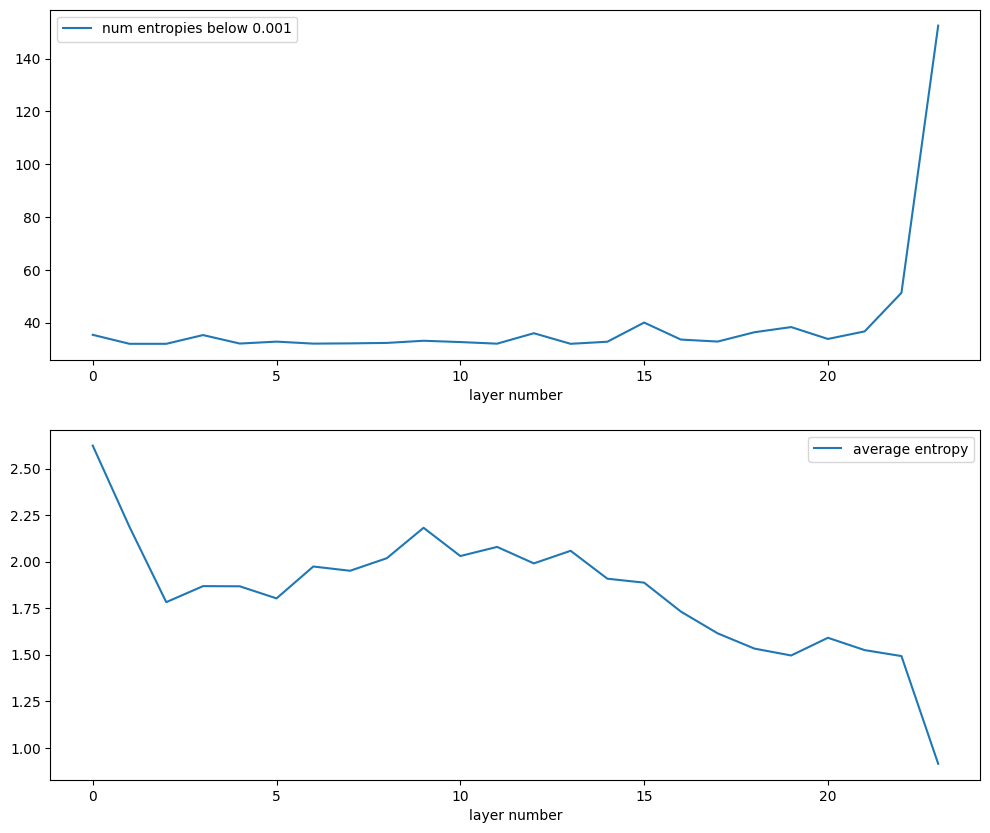

In [9]:
# graph entropy along with the number of sub threshold probs to give credence that that is the thing causing the drop.
layers = [i for i in range(24)]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
axes[0].set(xlabel='layer number')
axes[0].plot(layers, avg_num, label='num entropies below 0.001')
axes[0].legend()

axes[1].set(xlabel='layer number')
axes[1].plot(layers, averages, label='average entropy')
axes[1].legend()

plt.show()

Is us averaging without doing proportions incorrect? because it may have a different amount of avg_num's per story.
Investigate why there always seem to be 32 dead values... is one layer dead?